In [277]:
import seaborn as sns
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import rand, tensor, Tensor, nn

%matplotlib inline

sns.set_theme(style="white")


In [278]:
# 在头尾各添加一个维度，使得矩阵乘法输出维度为 1*1, 可以看作累乘作和的运算
x = torch.ones(2, 5).unsqueeze(1)
y = torch.ones(2, 5).unsqueeze(-1)

output = torch.bmm(x, y)

print(output, output.shape)

tensor([[[5.]],

        [[5.]]]) torch.Size([2, 1, 1])


## 带参数注意力汇聚

其中乘以 $w$ 作为可训练参数

$$
f(x) = \sum_{i=1}^n softmax(-\frac{1}{2}((x - x_i)w)^2)y_i
$$


通过计算查询 $x$ 和键值 $x_i$ 之间的距离 来作为优化函数

In [279]:
class NWKernelRegression(nn.Module):
    def __init__(self, ) -> None:
        super().__init__()
        self.w = nn.Parameter(rand(1, ), requires_grad = True)
    
    def forward(self, Q, K, V):
        # 将 query 复制, 使得Q和维度相同
        queries = Q.repeat_interleave(K.shape[1]).reshape((-1, K.shape[1]))
        
        assert queries.shape == K.shape, "dimension error with Key and Queries"

        self.attentionWeights = F.softmax(
            -((queries - K) * self.w)
            ** 2
            / 2,
            dim = 1
        )
        return torch.bmm(self.attentionWeights.unsqueeze(1), V.unsqueeze(-1)).reshape(-1)

In [280]:
class HyperParameter(nn.Module):
    def __init__(self, lr:float) -> None:
        super().__init__()
        self.w = nn.Parameter(rand(1, ), requires_grad = True)
        self.lr = lr
    def forward(self, Q, K, V):
        # 将 query 复制, 使得Q和维度相同
        queries = Q.repeat_interleave(K.shape[1]).reshape((-1, K.shape[1]))
        
        assert queries.shape == K.shape, "dimension error with Key and Queries"

        self.attentionWeights = F.softmax(
            -((queries - K) * self.w)
            ** 2
            / 2,
            dim = 1
        ) * self.lr
        # 对 softmax 回归进行一各缩放, lr > 1 则放大特征， < 1 则是消除一些小的特征
        
        return torch.bmm(self.attentionWeights.unsqueeze(1), V.unsqueeze(-1)).reshape(-1)

In [281]:
class LinearKernel(nn.Module):
    def __init__(self, queryNum, pairNum) -> None:
        super().__init__()
        self.w = nn.Parameter(rand(1, ), requires_grad = True)
        self.b = nn.Parameter(rand(1, ), requires_grad = True)
        self.Klinear = nn.Linear(queryNum, pairNum)
        self.Qlinear = nn.Linear(queryNum, pairNum)

    def forward(self, Q, K, V):
        # 将 query 复制, 使得Q和维度相同
        queries = Q.repeat_interleave(K.shape[1]).reshape((-1, K.shape[1]))
        
        # queries = self.Qlinear(queries)
        # K = self.Klinear(K)

        assert queries.shape == K.shape, "dimension error with Key and Queries"

        self.attentionWeights = F.softmax(
            -((queries - K) * self.w + self.b)
            ** 2
            / 2,
            dim = 1
        ) / torch.sqrt(50)

        return torch.bmm(self.attentionWeights.unsqueeze(1), V.unsqueeze(-1)).reshape(-1)

In [282]:
n_train = 50
x_train, _ = torch.sort(rand(n_train) * 5)

def f(x:tensor) -> Tensor:
    return 2 * torch.sin(x) + x ** 0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train, ))
x_test = torch.arange(0, 5, 0.1)

y_truth = f(x_test)
n_test = len(x_test)


In [283]:
# 将输入每一行重复 成为 Key
X_tile = x_train.repeat((n_train, 1))
# 将样本输出每一行对应重复, 成为 Value
Y_tile = y_train.repeat((n_train, 1))

# 将单位矩阵反转, 利用花式切片得到 Key, Value, 因为每一行都有一个元素是 0 （自身）不会被计算， 所以维度是 [n, n-1]
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

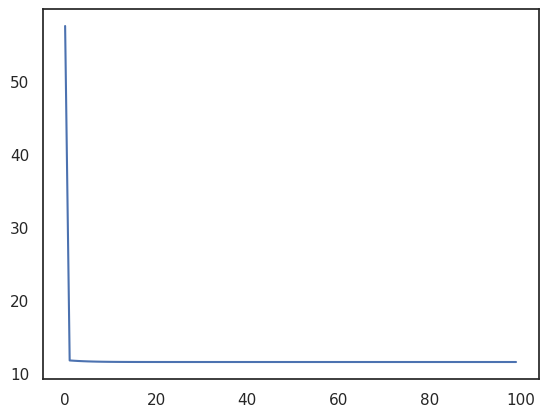

In [284]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction = 'none')
trainer = torch.optim.SGD(net.parameters(), lr = 0.5)

history = {
    'loss': []
}

for epoch in range(100):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    # print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    history['loss'].append(float(l.sum()))

plt.plot(history['loss'])

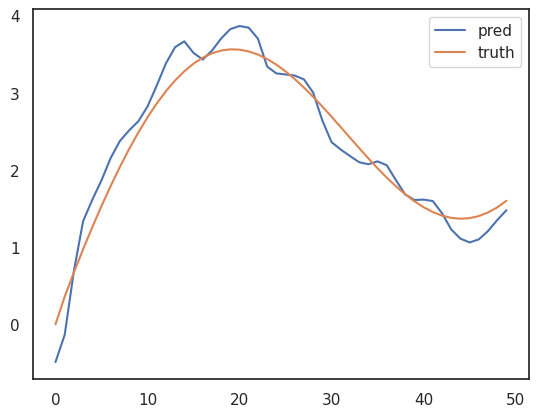

In [285]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))

y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plt.plot(y_hat, label = 'pred')
plt.plot(y_truth, label = 'truth')
plt.legend()

<Axes: >

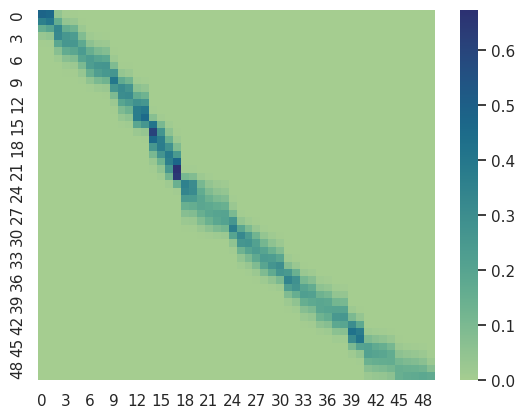

In [286]:
sns.heatmap(net.attentionWeights.detach(), cmap="crest")

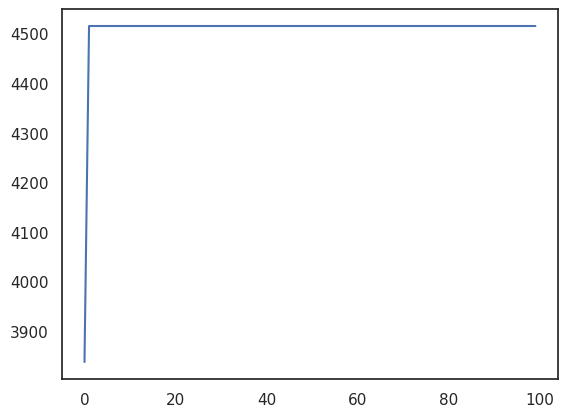

In [287]:
# net = LinearKernel(50, 50)
net = HyperParameter(5)
loss = nn.MSELoss(reduction = 'none')
trainer = torch.optim.SGD(net.parameters(), lr = 0.5)

history = {
    'loss': []
}

for epoch in range(100):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    # print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    history['loss'].append(float(l.sum()))

plt.plot(history['loss'])

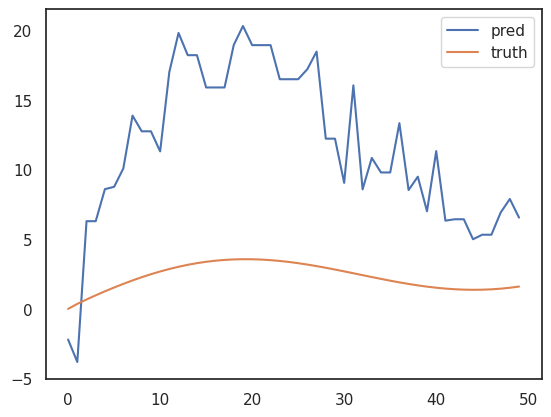

In [288]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))

y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plt.plot(y_hat, label = 'pred')
plt.plot(y_truth, label = 'truth')
plt.legend()

<Axes: >

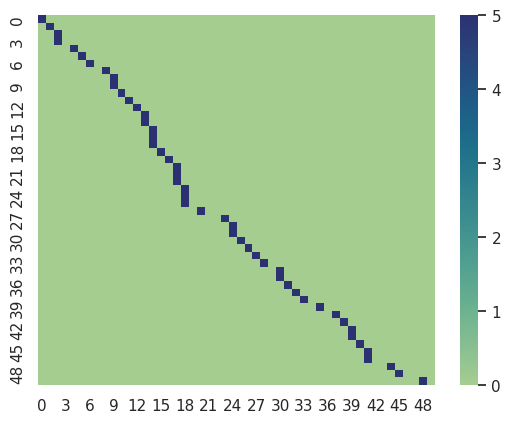

In [289]:
sns.heatmap(net.attentionWeights.detach(), cmap="crest")

# Q1

增加样本个数可能得到更好的非参数的 Nadaraya-Watson 核回归模型

因为它只会依赖于输入数据，并不会有一个“学习”的过程。

# Q2

增加可训练参数可以使得模型更好的学习到每个点的特征，而不是只看到全局的特征


